## **5장 합성곱 신경망 Ⅰ - Part 1**

### 5.2 합성곱 신경망 맛보기

In [ ]:
# 예제 진행을 위해 먼저 필요한 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [ ]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

일반적으로 하나의 GPU 사용할 때 사용하는 코드

```python
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)
```

사용하는 PC에서 다수의 GPU 사용한다면 `nn.DataParallell` 이용한다.

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
if torch.cuda.device_count() > 1:
	model = nn.DataParallel(net)
model.to(device)
```

nn.DataParallel 사용할 경우 배치 크기(batch size)가 알아서 각 GPU로 분배되는 방식으로 작동한다. 따라서 GPU 수만큼 배치 크기도 늘려 주어야 한다.

In [ ]:
# google 드라이브 접근
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
file_path = "/content/gdrive/My Drive/Colab Notebooks/DLData"

In [ ]:
# fashion_mnist 데이터셋 내려받기 - 토치비전으로 다운로드
train_dataset = torchvision.datasets.FashionMNIST(file_path, download=True,
                    transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(file_path, download=True,
                    train=False, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:11<00:00, 2226425.97it/s]


Extracting /content/gdrive/My Drive/Colab Notebooks/DLData/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/My Drive/Colab Notebooks/DLData/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208899.49it/s]


Extracting /content/gdrive/My Drive/Colab Notebooks/DLData/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/My Drive/Colab Notebooks/DLData/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3698584.65it/s]


Extracting /content/gdrive/My Drive/Colab Notebooks/DLData/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/My Drive/Colab Notebooks/DLData/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3264632.14it/s]


Extracting /content/gdrive/My Drive/Colab Notebooks/DLData/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/My Drive/Colab Notebooks/DLData/FashionMNIST/raw



- fashion_mnist 데이터셋 내려받기
    - `torchvision.datasets`는 `torch.utils.data.Dataset`의 하위 클래스로 다양한 데이터셋(CIFAR, COCO, MNIST, ImageNet 등)을 포함함. torchvision.datasets에서 사용하는 주요한 파라미터는 다음과 같다.
        - `torchvision.datasets.FashionMNIST(file_path, download=True, transform=transforms.Compose([transforms.ToTensor()]))`
            - 첫 번째 파라미터 : FashionMNIST를 내려받을 위치를 지정함.
            - `download` : `download`를 `True`로 변경해 주면 첫 번째 파라미터의 위치에 해당 데이터셋이 있는지 확인한 후 내려받음.
            - `transform` : 이미지를 텐서(0~1)로 변경함.

In [ ]:
# fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

- `torch.utils.data.DataLoader()`를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서가 무작위로 섞이도록(shuffle) 할 수 있음. 데이터로더에서 사용하는 파라미터는 다음과 같다.
    - `torch.utils.data.DataLoader(train_dataset, batch_size=100)`
        - 첫 번째 파라미터 : 데이터를 불러올 데이터셋을 지정함.
        - `batch_size` : 데이터를 배치로 묶어 줌. 여기에서는 `batch_size=100`으로 지정했기 때문에 100개 단위로 데이터를 묶어서 불러옴.

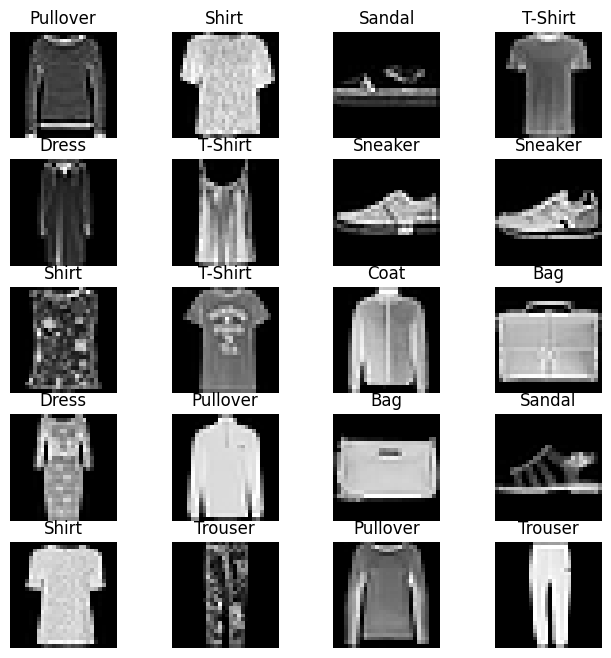

In [ ]:
# 분류에 사용될 클래스 정의

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat',
              5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : ' Ankel Boot'}
              # 열 개의 클래스

fig = plt.figure(figsize=(8,8));  # 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset));  # 1
    img = train_dataset[img_xy][0][0,:,:]    # 2
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()  # 20개의 이미지 데이터를 시각적으로 표현

- 분류에 사용될 클래스 정의
1. np.random은 무작위로 데이터를 생성할 때 사용함. 또한, np.random.randint()는 이산형분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용함. 따라서, random.randint(len(train_dataset)) 의미는 0~(train_dataset의 길이) 값을 갖는 분포에서 랜덤한 숫자 한 개를 생성하라는 의미.



In [ ]:
import numpy as np
np.random.randint(10)   # 0~10의 임의의 숫자 출력

1

In [ ]:
np.random.randint(1, 10)  # 1~9의 임의의 숫자 출력

1

In [ ]:
np.random.rand(8)   # 0~1 사이의 정규표준분포 난수를 행렬로 (1x8) 출력

array([0.05639381, 0.07600295, 0.34239702, 0.9702523 , 0.79199797,
       0.2514856 , 0.54702788, 0.09483049])

In [ ]:
np.random.rand(4,2) # 0~1 사이의 정규표준분포 난수를 행렬로 (4x2) 출력

array([[0.35844102, 0.53355576],
       [0.77988406, 0.66972546],
       [0.02581728, 0.9162391 ],
       [0.68924127, 0.12675577]])

In [ ]:
np.random.randn(8)  # 평균이 0, 표준편차가 1인 가우시안 정규분포 난수를 행렬로 (1x8) 출력

array([-0.61145638, -0.68840908,  0.02782313,  1.76315853,  2.89875225,
       -1.29642479,  0.16934627,  0.12456569])

In [ ]:
np.random.randn(4,2) # 평균이 0, 표준편차가 1인 가우시안 정규분포 난수를 행렬로 (4x2) 출력

array([[ 1.41926232, -0.79147623],
       [-1.48313733, -0.25834506],
       [ 0.78473483,  1.28084557],
       [-0.17477448,  0.36392679]])

2. train_dataset을 이용한 3차원 배열을 생성함.
    - 배열에 대한 사용 예시

In [ ]:
import numpy as np
examp = np.arange(0, 100, 3)  # 1~99의 숫자에서 3씩 건너뛴 행렬을 생성
examp.resize(6,4) # 행렬의 크기를 6x4로 조정
examp

array([[ 0,  3,  6,  9],
       [12, 15, 18, 21],
       [24, 27, 30, 33],
       [36, 39, 42, 45],
       [48, 51, 54, 57],
       [60, 63, 66, 69]])

In [ ]:
examp[3]  # 3행에 해당하는 모든 요소 출력

array([36, 39, 42, 45])

In [ ]:
examp[3,3]  # 3행 3번째 열에 대한 값 출력

45

In [ ]:
examp[3][3]  # 3행의 3번째 열에 대한 값을 출력(앞 결과에 동일)

45

In [ ]:
# train_dataset[img_xy][0][0,:,:] 의미 유추해보기
examp = np.arange(0, 500, 3)
examp.resize(3, 3, 5)
examp

array([[[  0,   3,   6,   9,  12],
        [ 15,  18,  21,  24,  27],
        [ 30,  33,  36,  39,  42]],

       [[ 45,  48,  51,  54,  57],
        [ 60,  63,  66,  69,  72],
        [ 75,  78,  81,  84,  87]],

       [[ 90,  93,  96,  99, 102],
        [105, 108, 111, 114, 117],
        [120, 123, 126, 129, 132]]])

In [ ]:
examp[2][0][3]

99

In [ ]:
# 심층 신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self):   # 1
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)  # 2
        self.drop = nn.Dropout(0.25)   # 3
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):   # 4
        out = input_data.view(-1, 784)   # 5
        out = F.relu(self.fc1(out))  # 6
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

1. 클래스(class) 형태의 모델은 항상 `torch.nn.Module` 상속받음. `__init__()`은 객체가 갖는 속성 값을 초기화하는 역할을 하며, 객체가 생성될 때 자동으로 호출됨. `super(FashionDNN, self).__init__()`은 FashionDNN이라는 부모(super) 클래스를 상속받겠다는 의미.
2. `nn`은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지, `Linear`는 단순 선형 회귀 모델을 만들 때 사용함. 이때 사용하는 파라미터는 다음과 같다.
    
    `nn.Linear(in_features=784, out_features=256)`
    
    1. in_features : 입력의 크기(input size)
    2. out_features : 출력의 크기(output size)
    
    실제로 데이터 연산이 진행되는 `forward()` 부분에는 첫 번째 파라미터 값만 넘겨주게 되며, 두 번째 파라미터에서 정의된 크기가 `forward()` 연산의 결과가 됨.
    
3. `torch.nn.Dropout(p)`는 p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커짐. 예를 들어 p=0.3이라는 의미는 전체 값 중 0.3의 확률로 0이 된다는 것, 0이 되지 않는 0.7에 해당하는 값은 (1/(1-0.7))만큼 커짐.
4. `forward()` 함수는 모델이 학습 데이터를 입력받아서 순전파 학습을 진행시키며, 반드시 forward라는 이름의 함수여야 함. 객체를 데이터와 함께 호출하면 자동으로 실행됨. 이때 순전파 연산이란 $H(x)$ 식에 입력 $x$로부터 예측된 $y$를 얻는 것.
5. 파이토치에서 사용하는 뷰(view) - 넘파이의 reshape과 같은 역할. 텐서의 크기(shape)를 변경해 주는 역할. 따라서 `input_data.view(-1, 784)`는 input_data를 `(?, 784)`의 크기로 변경하라는 의미. 첫 번째 차원(-1)은 사용자가 잘 모르겠으니 파이토치에 맡기겠다는 의미, 두 번째 차원의 길이는 784를 가지도록 하라는 의미.
6. 활성화 함수 지정하는 2가지 방법
    1. `F.relu()` : `forward()` 함수에서 정의
    2. `nn.ReLU()` : `__init__()` 함수에서 정의
    
    이 둘 간의 차이는 간단히 사용하는 위치라고 할 수 있음. 하지만 근본적으로는 `nn.functional.xx()`(혹은 `F.xx()`)와 `nn.xx()`는 사용 방법에 차이가 있음.

- nn 사용하는 코드
    ```
    import torch
    import torch.nn as nn

    inputs = torch.randn(64, 3, 244, 244)
    conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
    outputs = conv(inputs)
    layer = nn.Conv2d(1, 1, 3)
    ```



- nn.functional 사용하는 코드
    - 입력과 가중치 자체를 직접 넣어 줌.
    ```
    import torch.nn.functional as F

    inputs = torch.randn(64, 3, 244, 244)
    weight = torch.randn(64, 3, 3, 3)
    bias = torch.randn(64)
    outputs = F.conv2d(inputs, weight, bias, padding=1)
    ```


In [ ]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001 ;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss()  # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);  # 1
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


1. 옵티마이저를 위한 경사 하강법은 Adam을 사용하며, 학습률을 의미하는 lr은 0.001을 사용한다는 의미.

In [ ]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []   # 1
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:  # 2
        images, labels = images.to(device), labels.to(device)   # 3

        train = Variable(images.view(100, 1, 28, 28))  # 4
        labels = Variable(labels)

        outputs = model(train)  # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):  # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                prediction_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total  # 5
            loss_list.append(loss.data)  # 1'
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data,
                                                                  accuracy))

Iteration: 500, Loss: 0.5680888891220093, Accuracy: 83.5%
Iteration: 1000, Loss: 0.4745977818965912, Accuracy: 84.4000015258789%
Iteration: 1500, Loss: 0.36127376556396484, Accuracy: 84.4000015258789%
Iteration: 2000, Loss: 0.37064266204833984, Accuracy: 85.58000183105469%
Iteration: 2500, Loss: 0.23095816373825073, Accuracy: 85.86000061035156%
Iteration: 3000, Loss: 0.27180230617523193, Accuracy: 86.62000274658203%


1. 1’. 일반적으로 배열이나 행렬과 같은 리스트(list)를 사용하는 방법은 다음과 같다.
    1. 1과 같이 비어 있는 배열이나 행렬을 만듦.
    2. 1’처럼 `append` 메서드를 이용하여 데이터를 하나씩 추가함.
2. for 구문을 이용하여 레코드(행, 가로줄)를 하나씩 가져옴. 이때 `for x, y in train:` 과 같이 in 앞에 변수 두 개 지정해 주면 레코드에서 요소 두 개를 꺼내 오겠다는 의미.
3. 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치(CPU, GPU)에 있어야 함. model.to(device)가 GPU 사용했다면, images.to(device), labels.to(device)도 GPU에서 처리되어야 함. 참고로 CPU에서 처리된 데이터를 GPU 모델에 적용하거나 그 반대의 경우 런타임 오류 발생함.
4. Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지로, 자동 미분에 대한 값을 저장하기 위해 테이프(tape)를 사용함. 순전파 단계에서 테이프는 수행하는 모든 연산을 저장함. 그리고 역전파 단계에서 저장된 값들을 꺼내서 사용함. 즉, Autograd는 Variable을 사용해서 역전파를 위한 미분 값을 자동으로 계산해 줌. 따라서 자동 미분을 계산하기 위해서는 `torch.autograd` 패키지 안에 있는 `Variable` 이용해야 동작함.
5. 분류 문제에 대한 정확도는 전체 예측에 대한 정확한 예측의 비율로 표현할 수 있음.
    
    `classificationi accuracy = correct predictions / total predictions`
    
    이때 결과에 100을 곱하여 백분율로 표시하는 코드
    
    `classification accuracy = correct predictions / total predictions * 100`
    
    또한, 분류 문제에 대한 정확도는 다음과 같이 값을 반전시켜 오분류율 또는 오류율로 표현할 수 있음.
    
    `error rate = (1 - (correct predictions / total predictions)) * 100`
    
    분류 문제에서 클래스가 3개 이상일 때 다음과 같은 사항에 주의하자.
    
    - 정확도가 80% 이상이었다고 하자. 하지만 80%라는 값이 모든 클래스가 동등하게 고려된 것인지, 특정 클래스의 분류가 높았던 것인지에 대해 알 수 없음에 유의해야 함.
    - 정확도가 90% 이상이었다고 하자. 하지만 100개의 데이터 중 90개가 하나의 클래스에 속할 경우 90%의 정확도는 높다고 할 수 없음. 즉, 모든 데이터를 특정 클래스에 속한다고 예측해도 90%의 예측 결과가 나오기 때문에 데이터 특성에 따라 정확도를 잘 관측해야 함.

In [ ]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(   # 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # 2
            nn.BatchNorm2d(32),  # 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 4
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)  # 5
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        # 마지막 계층의 out_features 클래스 개수 의미

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # 6
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

1. `nn.Sequential`을 사용하면 `__init__()` 에서 사용할 네트워크 모델들을 정의해 줄 뿐만 아니라, forward() 함수에서 구현될 순전파를 계층(layer) 형태로 조금 더 가독성 뛰어난 코드로 작성할 수 있음. 즉, `nn.Sequential` 은 계층을 차례로 쌓을 수 있도록 $Wx+b$와 같은 수식과 활성화 함수를 연결해 주는 역할. 특히 데이터가 각 계층을 순차적으로 지나갈 때 사용하면 좋은 방법.
2. 합성곱층(conv layer)은 합성곱 연산을 통해서 이미지의 특성을 추출함. 합성곱이란 커널(또는 필터)이라는 n x m 크기의 행렬이 높이 x 너비 크기의 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력함. 커널을 일반적으로 3x3이나 5x5를 사용하며 사용하는 파라미터는 다음과 같다.
    
    `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)`
    
    1. `in_channels` : 입력 채널 수. 흑백 이미지는 1, RGB 값을 가진 이미지는 3을 가진 경우가 많음. (채널이란? 2차원은 행렬, 3차원으로 생각하면 채널은 결국 깊이(depth)를 의미함.)
    2. `out_channels` : 출력 채널의 수.
    3. `kernel_size` : 커널 크기를 의미. 논문에 따라 필터라고도 함. 이미지 특징을 찾아내기 위한 공용 파라미터, CNN에서 학습 대상은 필터 파라미터가 됨. 입력 데이터를 스트라이드 간격으로 순회하면서 합성곱을 계산함.
    4. `padding` : 패딩 크기를 의미. 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채움. 패딩 값이 클수록 출력 크기도 커짐.
3. `BatchNorm2d`는 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것. 배치 단위나 계층에 따라 입력 값의 분포가 모두 다르지만 정규화를 통해 분포를 가우시안 형태로 만듦. 그러면 평균은 0, 표준편차는 1로 데이터의 분포가 조정됨.
    
4. MaxPool2d는 이미지 크기를 축소시키는 용도로 사용함. 풀링 계층은 합성곱층의 출력 데이터를 입력으로 받아서 출력 데이터(activation map)의 크기를 줄이거나 특정 데이터를 강조하는 용도. 풀링 계층을 처리하는 방법으로는 최대 풀링과 평균 풀링, 최소 풀링이 있으며, 이때 사용하는 파라미터는 다음과 같다.
    
    `nn.MaxPool2d(kernel_size=2, stride=2)`
    
    1. `kernel_size` : m x n 행렬로 구성된 가중치
    2. `stride` : 입력 데이터에 커널(필터) 적용할 때 이동할 간격. 스트라이드 값이 커지면 출력 크기는 작아짐.
5. 클래스를 분류하기 위해서는 이미지 형태의 데이터를 배열 형태로 변환하여 작업해야 함. 이때 Conv2d에서 사용하는 하이퍼파라미터 값들에 따라 출력 크기(output size)가 달라짐. 즉, 패딩과 스트라이드 값에 따라 출력 크기가 달라짐. 이렇게 줄어든 출력 크기는 최종적으로 분류를 담당하는 완전연결층으로 전달됨.
    
    `nn.Linear(in_features=64*6*6, out_features=600)`
    
    1. `in_features` : 입력 데이터의 크기. 중요한 것은 이전까지 수행했던 Conv2d, MaxPool2d는 이미지 데이터를 입력으로 받아 처리. 하지만 그 출력 결과를 완전연결층으로 보내기 위해서는 1차원으로 변경해주어야 함.
    2. `out_features` : 출력 데이터의 크기.

6. 합성곱층에서 완전연결층으로 변경되기 때문에 데이터 형태를 1차원으로 바꾸어 줌.
    
    이때 `out.size(0)`은 결국 100을 의미. 따라서 (100, ?) 크기의 텐서로 변경하겠다는 의미.

In [ ]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data,
                                                                  accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4088139235973358, Accuracy: 88.04000091552734%
Iteration: 1000, Loss: 0.3328262269496918, Accuracy: 87.66999816894531%
Iteration: 1500, Loss: 0.32969874143600464, Accuracy: 86.88999938964844%
Iteration: 2000, Loss: 0.1952207386493683, Accuracy: 89.81999969482422%
Iteration: 2500, Loss: 0.15382444858551025, Accuracy: 89.87999725341797%
Iteration: 3000, Loss: 0.19113150238990784, Accuracy: 90.44999694824219%


- 심층 신경망과 비교하여 정확도가 약간 높음.
- 심층 신경망과 별 차이가 없기 때문에 좀 더 간편한 심층 신경망만 사용해도 무난할 것 같지만 실제로 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능. 합성곱 신경망 생성할 수 있도록 학습해야 함.